<a href="https://colab.research.google.com/github/AlejandroSepulvedaGuatecique/Projects-in-Ml-and-AI-/blob/main/HW5/HW5_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 5: CNNs, AEs, GANs

**USEFUL RESOURCES**

https://towardsdatascience.com/synthetic-data-generation-using-conditional-gan-45f91542ec6b

https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

https://keras.io/api/applications/

## PROJECT DESIGN AND IMPLEMENTATION

The objective of this project is to develop a Convolutional Neural Network, Variational Auto Encoder and Generative Adversarial Network, to classify clothing articles based on images and reproduced high quality synthetic images. The data set is provided by Zalando which is a publicly traded German online retailer of clothing articles. The data set contains 70000 images with the associated classification label. Each image is given as a 28x28 grayscale format. Each pixel is represented by single pixel-value indicating the lightness or darkness of the pixel. The higher the number the darker the pixel is. The pixel value is an integer between 0 and 255. The data set can be downloaded from this link [Data](https://github.com/zalandoresearch/fashion-mnist)

### EXPLORATORY DATA ANALYSIS

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [18]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X = np.concatenate((X_train,X_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

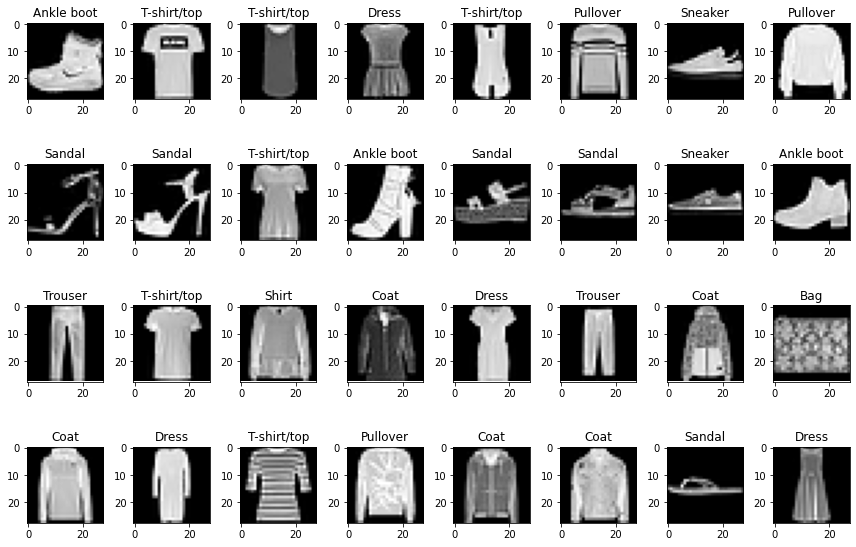

In [27]:
# specify the number of rows and columns you want to see
num_row = 4
num_col = 8

# get a segment of the dataset
num = num_row*num_col
images = X[:num]
labels = y[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('{}'.format(class_names[labels[i]]))
plt.tight_layout()
plt.show()

Here, we can see a sample of the data set. The data set are images of 10 different clothing articles in grey scale. The labels goes from 0 to 9 and the definition is as follows:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

Based on the images, one can expect different challenges. The clothing articles coat, pullover, dress and t-shirt/top have a similar shape and it is possible that a human would made some errors when labeling these articles based on grey scale image. The same comment may apply to sneakers, sandals and angle boats. On the other hand, trouser and bag may be easier to identify. These comments are based from a human perspective. During the analysis these comments will be verified. Nevertheless anticipating possible problems it is a good practice to planned areas to improved on. 

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 7000]
 [   1 7000]
 [   2 7000]
 [   3 7000]
 [   4 7000]
 [   5 7000]
 [   6 7000]
 [   7 7000]
 [   8 7000]
 [   9 7000]]


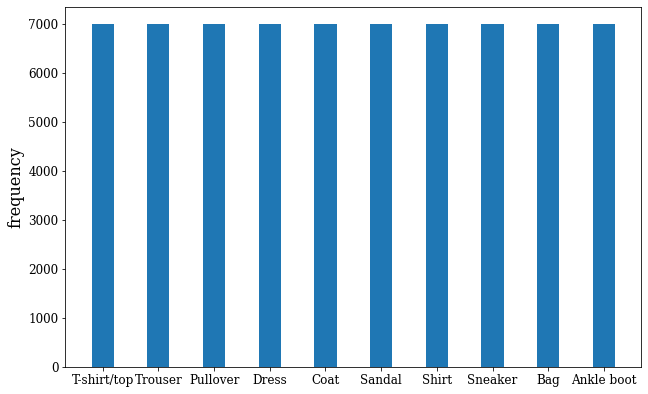

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])
students = counts
ax.bar(class_names,students,0.4)
fontdict={  'fontsize': 16, 'fontname': 'serif'}
ax.set_ylabel('frequency',fontdict)
for tick in ax.get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in ax.get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
plt.show()

This bar graph shows the data distribution among the labels. The data set is evenly distributed among each clothing article. Each label has 7000 examples. Data distribution is important since it may lead to biased models when the data is not evenly distributed. 

### TRAIN-DEV-TEST SPLIT

Here we will pre-process the data. The data is initially given as a train and test set. However, for this project we want to split the data in three parts: training, validation and test data sets. Also, the pixel-values should be normalized. In this work, they will be normalized to have a range between 0 and 1, therefore all the pixel values will be divided by 255. 

In [19]:
# loading the data
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X = np.concatenate((X_train,X_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
X = X/255.0

In addition the data should be shuffle before it is used to train the Neural network.  Finally, the data is splitted in three parts as follows: 80% to the training data set and 10% for both the validation and test data set. 

In [20]:
np.random.seed(42)
A = np.arange(0,69999)
np.random.shuffle(A)
train, validate, test = np.split(A,[int(.8*len(A)), int(.9*len(A))])
X_train = X[train]
X_val = X[validate]
X_test = X[test]
y_train = y[train]
y_val = y[validate]
y_test = y[test]
print('X_train shape is: ' + str(X_train.shape))
print('X_val shape is:  '  + str(X_val.shape))
print('X_test shape is:  '  + str(X_test.shape))
print('y_train shape is: ' + str(y_train.shape))
print('y_val shape is:  '  + str(y_val.shape))
print('y_test shape is:  '  + str(y_test.shape))

X_train shape is: (55999, 28, 28)
X_val shape is:  (7000, 28, 28)
X_test shape is:  (7000, 28, 28)
y_train shape is: (55999,)
y_val shape is:  (7000,)
y_test shape is:  (7000,)


## BUILDING CONVOLUTIONAL NEURAL NETWORK MODEL

A Convolutional Neural Network (CNN) is defined to classify the images from the fashion MNIST data set. The CNN architecture is based on a pattern of a 2D convolutional layer follows by a maxpooling layer of size 2 by 2. The max pooling layer objective is to summarize the information of the image by reducing its size, a 2 by 2 size is selected because has proven to be a good max pooling size. Also the size of our images is 28 by 28, a larger size of the maxpooling layer may lead to information loss of the image. The convolutional layers have a kernel of size 3 by 3. The filters goes from 12 to 24. The pattern extraction at the beggining of the CNN is basic, usually it detects edges and lines, therefore a small number of filters is defined for the first layer. In the second layer, the model can identify more complex patterns as clothes in this case. 

In [ ]:
from tensorflow.keras import layers, models
model = models.Sequential()
# The first part of the model is the feature extraction and it is done through 
# Convolution and the Pooling Layer
model.add(layers.Conv2D(filters=12, kernel_size=(3,3),
                        activation='relu', input_shape = (28,28,1)))   # input_shape	Shape tuple (not including the batch axis), or TensorShape instance (not including the batch axis).
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=24, kernel_size=(3,3),
                        activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# Second part, the feature extraction is finished. Next we will be flatten the data to one-dimension
model.add(layers.Flatten())
# Classification Section (The Fully Connected Layer)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
# Show summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 24)        2616      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 24)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 128)               7

## DEFINING COST FUNCTION AND GRADIENT DESCENT IMPLEMENTATION

For this work, the Sparse Categorical Cross entropy is used as the loss function. The hyperparameters are trained using the gradient descent algorithm and the Adam optimization is applied. The metric used to evaluate this ML model is accuracy. The accuracy is the ratio between the corrected predictions over the number of test instances. This metric is selected since there is no particular reason to prioratize recall or precision over the predictions. A miss-classification of a particular label is as important as other labels.

In [ ]:
# Compile The Model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Fit And Evaluate The Model Using Validation Dataset
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
1750/1750 [==============================] - 37s 21ms/step - loss: 0.4132 - accuracy: 0.8496 - val_loss: 0.3610 - val_accuracy: 0.8711
Epoch 2/50
1750/1750 [==============================] - 36s 21ms/step - loss: 0.3336 - accuracy: 0.8758 - val_loss: 0.3154 - val_accuracy: 0.8877
Epoch 3/50
1750/1750 [==============================] - 40s 23ms/step - loss: 0.2932 - accuracy: 0.8929 - val_loss: 0.2908 - val_accuracy: 0.8964
Epoch 4/50
1750/1750 [==============================] - 36s 20ms/step - loss: 0.2649 - accuracy: 0.9024 - val_loss: 0.2932 - val_accuracy: 0.8933
Epoch 5/50
1750/1750 [==============================] - 36s 21ms/step - loss: 0.2450 - accuracy: 0.9090 - val_loss: 0.2780 - val_accuracy: 0.9024
Epoch 6/50
1750/1750 [==============================] - 37s 21ms/step - loss: 0.2264 - accuracy: 0.9159 - val_loss: 0.2732 - val_accuracy: 0.9046
Epoch 7/50
1750/1750 [==============================] - 37s 21ms/step - loss: 0.2092 - accuracy: 0.9221 - val_loss: 0.2629 -

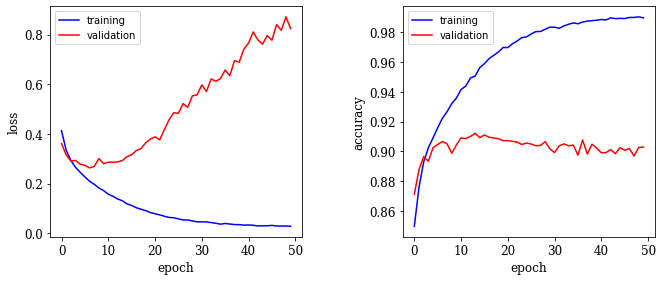

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(history.history['loss'],'-b', label = 'training')
axes[0].plot(history.history['val_loss'],'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(history.history['accuracy'],'-b', label = 'training')
axes[1].plot(history.history['val_accuracy'],'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('accuracy',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

The plot shows the loss and accuracy of the CNN for the training and validation set. It can be seen that the loss and accuracy decrease with the number of epochs until 10 epochs are reached. Beyond this point the loss increases while the accuracy decreases for the validation set. The opposite occurs to the training set, this is a clear sign of overfitting. At 10 epochs the loss on the validation set is equal to 0.3 and the accuracy is equal to 0.91.

## EFFECT OF THE NUMBER OF LAYERS 

In [30]:
from tensorflow.keras import layers, models
model = models.Sequential()
# The first part of the model is the feature extraction and it is done through 
# Convolution and the Pooling Layer
model.add(layers.Conv2D(filters=12, kernel_size=(3,3),
                        activation='relu', input_shape = (28,28,1)))   # input_shape	Shape tuple (not including the batch axis), or TensorShape instance (not including the batch axis).
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=24, kernel_size=(3,3),
                        activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=48, kernel_size=(3,3),
                        activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# Second part, the feature extraction is finished. Next we will be flatten the data to one-dimension
model.add(layers.Flatten())
# Classification Section (The Fully Connected Layer)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
# Show summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 12)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 24)        2616      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 24)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 48)          10416     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 48)        

In [31]:
# Compile The Model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Fit And Evaluate The Model Using Validation Dataset
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1750/1750 [==============================] - 39s 22ms/step - loss: 0.6602 - accuracy: 0.7565 - val_loss: 0.5246 - val_accuracy: 0.8107
Epoch 2/30
1750/1750 [==============================] - 36s 20ms/step - loss: 0.4603 - accuracy: 0.8338 - val_loss: 0.4396 - val_accuracy: 0.8366
Epoch 3/30
1750/1750 [==============================] - 37s 21ms/step - loss: 0.4092 - accuracy: 0.8504 - val_loss: 0.4207 - val_accuracy: 0.8447
Epoch 4/30
1750/1750 [==============================] - 37s 21ms/step - loss: 0.3743 - accuracy: 0.8627 - val_loss: 0.3733 - val_accuracy: 0.8594
Epoch 5/30
1750/1750 [==============================] - 36s 20ms/step - loss: 0.3499 - accuracy: 0.8712 - val_loss: 0.3587 - val_accuracy: 0.8634
Epoch 6/30
1750/1750 [==============================] - 38s 22ms/step - loss: 0.3294 - accuracy: 0.8781 - val_loss: 0.3473 - val_accuracy: 0.8707
Epoch 7/30
1750/1750 [==============================] - 37s 21ms/step - loss: 0.3125 - accuracy: 0.8845 - val_loss: 0.3679 -

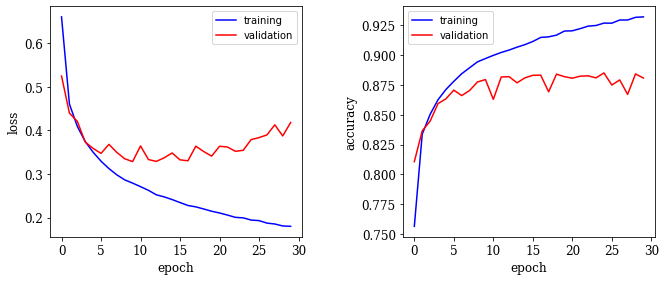

In [32]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(history.history['loss'],'-b', label = 'training')
axes[0].plot(history.history['val_loss'],'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(history.history['accuracy'],'-b', label = 'training')
axes[1].plot(history.history['val_accuracy'],'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('accuracy',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

We can see how the loss decreased and the accuracy increased with the number of epochs until 10 epochs were reached. After this point the validation loss and accuracy start increasing, indicating overfitting issues. At 10 epochs the accuracy and loss of the CNN model is equal to 0.875 and 0.38 respectively. This performance is lower with respect to the simpler model above. Which indicates that the current model may be over-estimating the complexity of the problem. Therefore the simpler is selected. 

## FINAL MODEL

In [33]:
from tensorflow.keras import layers, models
model = models.Sequential()
# The first part of the model is the feature extraction and it is done through 
# Convolution and the Pooling Layer
model.add(layers.Conv2D(filters=12, kernel_size=(3,3),
                        activation='relu', input_shape = (28,28,1)))   # input_shape	Shape tuple (not including the batch axis), or TensorShape instance (not including the batch axis).
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=24, kernel_size=(3,3),
                        activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# Second part, the feature extraction is finished. Next we will be flatten the data to one-dimension
model.add(layers.Flatten())
# Classification Section (The Fully Connected Layer)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
# Show summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 24)        2616      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 24)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 600)               0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [34]:
# Compile The Model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Fit And Evaluate The Model Using Validation Dataset
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1750/1750 [==============================] - 36s 20ms/step - loss: 0.5289 - accuracy: 0.8091 - val_loss: 0.4212 - val_accuracy: 0.8431
Epoch 2/10
1750/1750 [==============================] - 35s 20ms/step - loss: 0.3546 - accuracy: 0.8707 - val_loss: 0.3518 - val_accuracy: 0.8747
Epoch 3/10
1750/1750 [==============================] - 33s 19ms/step - loss: 0.3082 - accuracy: 0.8883 - val_loss: 0.3181 - val_accuracy: 0.8857
Epoch 4/10
1750/1750 [==============================] - 34s 19ms/step - loss: 0.2804 - accuracy: 0.8964 - val_loss: 0.2938 - val_accuracy: 0.8929
Epoch 5/10
1750/1750 [==============================] - 33s 19ms/step - loss: 0.2587 - accuracy: 0.9049 - val_loss: 0.3122 - val_accuracy: 0.8846
Epoch 6/10
1750/1750 [==============================] - 34s 19ms/step - loss: 0.2384 - accuracy: 0.9111 - val_loss: 0.2799 - val_accuracy: 0.9024
Epoch 7/10
1750/1750 [==============================] - 34s 19ms/step - loss: 0.2221 - accuracy: 0.9175 - val_loss: 0.2576 -

In [35]:
loss, acc = model.evaluate(X_test, y_test, verbose = 1)
print('\nTest accuracy: %5.2f' %(acc))
print('\nTest loss: %5.2f' %(loss))

219/219 [==============================] - 2s 8ms/step - loss: 0.2652 - accuracy: 0.9041

Test accuracy:  0.90

Test loss:  0.27


Finally, an accuracy equal to 90% and a loss equal to 0.27 is obtained with the test set. The level of accuracy demonstrate that the model was successfully implemented. 

## TRANSFER LEARNING: PRETRAINED MODELS

In this section, two pretrained models (InceptionV3 and ResNet50) will be used to classify clothes items in our data set. InceptionV3 is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatenations, dropouts, and fully connected layers. Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax. While, ResNet50 is a convolutional neural network that is 50 layers deep. Both models were trained on RGB images with higher resolution than our data set (28 by 28).

The first 4 images in our training data set are a T-shirt, two bags and a shirt. 

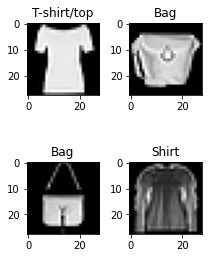

In [21]:
# specify the number of rows and columns you want to see
num_row = 2
num_col = 2

# get a segment of the dataset
num = num_row*num_col
images = X_train[:num]
labels = y_train[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('{}'.format(class_names[labels[i]]))
plt.tight_layout()
plt.show()

Note that the InceptionV3 and ResNet50 models expect RGB figures and our data set is on grayscale. Therefore, the data set need to be transformed to an RGB format. This can be achieve by repeating the image along the depth axis.  Also, the size of the image is resized to be 299 by 299 for InceptionV3 and 224 by 224 for the ResNet50 model. 

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
from skimage.transform import resize
import cv2
#####################################
model = InceptionV3(weights='imagenet')

######################################
image_1 = resize(X_train[0,:,:], (299, 299))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_0 = model.predict(x)

######################################
image_1 = resize(X_train[1,:,:], (299, 299))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_1 = model.predict(x)

######################################
image_1 = resize(X_train[2,:,:], (299, 299))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_2 = model.predict(x)

######################################
image_1 = resize(X_train[3,:,:], (299, 299))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_3 = model.predict(x)

print('Predicted:', decode_predictions(preds_0, top=5))
print('Predicted:', decode_predictions(preds_1, top=5))
print('Predicted:', decode_predictions(preds_2, top=5))
print('Predicted:', decode_predictions(preds_3, top=5))

(1, 299, 299, 3)


1/1 [==============================] - 2s 2s/step
(1, 299, 299, 3)
1/1 [==============================] - 0s 266ms/step
(1, 299, 299, 3)
1/1 [==============================] - 0s 257ms/step
(1, 299, 299, 3)
1/1 [==============================] - 0s 282ms/step
Predicted: [[('n01930112', 'nematode', 0.11510847), ('n03729826', 'matchstick', 0.07443289), ('n03196217', 'digital_clock', 0.036717094), ('n03590841', "jack-o'-lantern", 0.020526238), ('n04286575', 'spotlight', 0.01962468)]]
Predicted: [[('n01930112', 'nematode', 0.11149525), ('n03729826', 'matchstick', 0.06841346), ('n03196217', 'digital_clock', 0.036050107), ('n03590841', "jack-o'-lantern", 0.022400137), ('n04286575', 'spotlight', 0.017972318)]]
Predicted: [[('n01930112', 'nematode', 0.12056431), ('n03729826', 'matchstick', 0.06923175), ('n03196217', 'digital_clock', 0.037985392), ('n03590841', "jack-o'-lantern", 0.02255632), ('n04286575', 'spotlight', 0.01793841)]]
Predicted: [[('n01930112', 'nematode', 0.11988732), ('n0372982

In [28]:
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from skimage.transform import resize
import cv2
######################################
model = ResNet50(weights='imagenet')
######################################
image_1 = resize(X_train[0,:,:], (224, 224))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_0 = model.predict(x)

######################################
image_1 = resize(X_train[1,:,:], (224, 224))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_1 = model.predict(x)

######################################
image_1 = resize(X_train[2,:,:], (224, 224))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_2 = model.predict(x)

######################################
image_1 = resize(X_train[3,:,:], (224, 224))
x = np.repeat(image_1[..., np.newaxis], 3, -1)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
################################
preds_3 = model.predict(x)

print('Predicted:', decode_predictions(preds_0, top=5))
print('Predicted:', decode_predictions(preds_1, top=5))
print('Predicted:', decode_predictions(preds_2, top=5))
print('Predicted:', decode_predictions(preds_3, top=5))

(1, 224, 224, 3)
1/1 [==============================] - 1s 1s/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 229ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 232ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 227ms/step
Predicted: [[('n06359193', 'web_site', 0.057317644), ('n03196217', 'digital_clock', 0.05255674), ('n01930112', 'nematode', 0.049493406), ('n03729826', 'matchstick', 0.043166097), ('n04404412', 'television', 0.027662577)]]
Predicted: [[('n06359193', 'web_site', 0.06351207), ('n04404412', 'television', 0.045541376), ('n01930112', 'nematode', 0.043506373), ('n03196217', 'digital_clock', 0.042027865), ('n03782006', 'monitor', 0.038475867)]]
Predicted: [[('n06359193', 'web_site', 0.062117252), ('n01930112', 'nematode', 0.054597173), ('n03729826', 'matchstick', 0.049268022), ('n03196217', 'digital_clock', 0.045173276), ('n04404412', 'television', 0.026656426)]]
Predicted: [[('n06359193', 'web_site', 0.064330794), ('n019

The pretrained models were not able to correctly classify the data set. Note that our data set has a low quality (28 by 28) and it is in grey scale. The pretrained models were not input this type of data, specially with the greyscale format. Therefore, it is expected that they are not able to properly classify the data set. We can evaluate how the models performed with RGB and medium quality images. 

A picture of a jacket is uploaded to evaluate the pretrained model performance

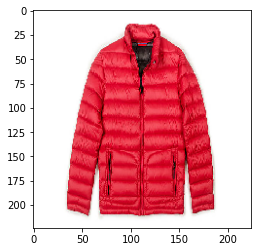

In [7]:
import matplotlib.pyplot as plt
# pick a sample to plot
sample = 3
image_1 = x

# plot the sample
fig = plt.figure
plt.imshow(img)
plt.show()

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'Jacket.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03404251', 'fur_coat', 0.2661389), ('n02769748', 'backpack', 0.16772625), ('n04525038', 'velvet', 0.16455306)]


The ResNet50 model was able to classify the image as a coat

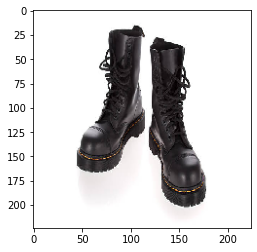

In [30]:
import matplotlib.pyplot as plt
img_path = 'boots.jpg'
img = image.load_img(img_path, target_size=(224, 224))
# plot the sample
fig = plt.figure
plt.imshow(img)
plt.show()

In [8]:
img_path = 'boots.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 205ms/step
Predicted: [('n03124043', 'cowboy_boot', 0.9501664), ('n02910353', 'buckle', 0.014880242), ('n04254777', 'sock', 0.010674056)]


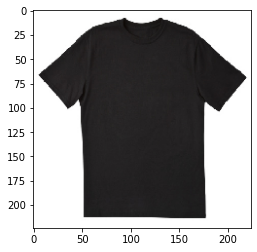

In [31]:
import matplotlib.pyplot as plt
img_path = 'tshirt.jpg'
img = image.load_img(img_path, target_size=(224, 224))
# plot the sample
fig = plt.figure
plt.imshow(img)
plt.show()

In [9]:
img_path = 'tshirt.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 210ms/step
Predicted: [('n03595614', 'jersey', 0.99931395), ('n04370456', 'sweatshirt', 0.00040268354), ('n02667093', 'abaya', 0.00014360191)]


The ResNet model was able to correctly classify all the clothes items from an RGB image. This is expected especially regarding the issue with the RGB and greyscale images since the weights were trained for RGB images and therefore they expect to extract different information from each channel. Although we can use the pretrained models with grayscale images by transforming them to RGB shape by repeating the image, the models may extract wrongly features of the transformed images, since the models are expecting an RGB image input. 

## DATA AUGMENTATION

In this section data augmentation techniques are implemented to increase the diversity of my data set. This approach is helpful when small data sets are available. In this section, random rotations, shift and flips are implemented to the images. 30000 new images are added to training data set. Note that the current training set presents 56000 images. 

### RANDOM ROTATIONS

Random rotations are apply between 0 and 90 degrees. 

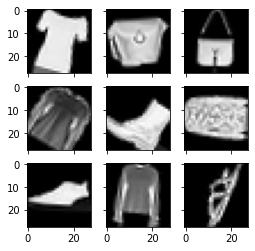

In [46]:
from keras.preprocessing.image import ImageDataGenerator
X_train_r = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_r = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(rotation_range=90)
for X_batch, y_batch in datagen.flow(X_train_r, y_train, batch_size=9, shuffle=False): #X_batch and y_batch contains the data set with the rotated images
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break
for X_batch_rot, y_batch_rot in datagen.flow(X_train_r, y_train, batch_size=10000, shuffle=False): #X_batch and y_batch contains the data set with the rotated images
    break

### RANDOM SHIFT

In this section the images are shift to the left or to the right randomly. 

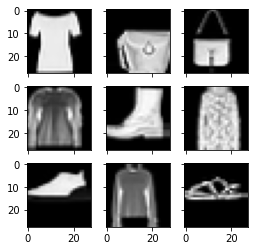

In [47]:
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

for X_batch_shift, y_batch_shift in datagen.flow(X_train, y_train, batch_size=10000, shuffle=False):
    break

### RANDOM FLIPS 

In this part, the images are flip to the left or to the right randomly.

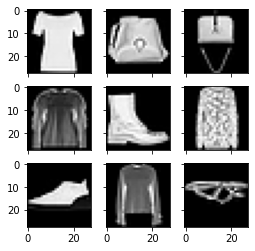

In [48]:
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

for X_batch_flips, y_batch_flips in datagen.flow(X_train, y_train, batch_size=10000, shuffle=False):
    break

## BUILDING MODEL WITH NEW DATA FROM DATA AUGMENTATION TECHNIQUES

The effect of increasing the diversity and samples of our data set will be assessed in this section. The generated data through data augmentation techniques will be concatenated with training data set. 

In [58]:
import sklearn as sklearn
X = np.concatenate((X_batch_rot,X_batch_shift,X_batch_flips,X_train), axis=0)
y = np.concatenate((y_batch_rot,y_batch_shift,y_batch_flips,y_train), axis=0)

X_aug, y_aug = sklearn.utils.shuffle(X,y, random_state=3)

In [79]:
from tensorflow.keras import layers, models
model = models.Sequential()
# The first part of the model is the feature extraction and it is done through 
# Convolution and the Pooling Layer
model.add(layers.Conv2D(filters=12, kernel_size=(3,3),
                        activation='relu', input_shape = (28,28,1)))   # input_shape	Shape tuple (not including the batch axis), or TensorShape instance (not including the batch axis).
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=24, kernel_size=(3,3),
                        activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
# Second part, the feature extraction is finished. Next we will be flatten the data to one-dimension
model.add(layers.Flatten())
# Classification Section (The Fully Connected Layer)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
# Show summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 24)        2616      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 24)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 600)               0         
                                                                 
 dense_20 (Dense)            (None, 128)              

In [62]:
# Compile The Model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Fit And Evaluate The Model Using Validation Dataset
history = model.fit(X_aug, y_aug, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2688/2688 [==============================] - 53s 19ms/step - loss: 0.7232 - accuracy: 0.7387 - val_loss: 0.4078 - val_accuracy: 0.8566
Epoch 2/30
2688/2688 [==============================] - 52s 20ms/step - loss: 0.4843 - accuracy: 0.8222 - val_loss: 0.3450 - val_accuracy: 0.8799
Epoch 3/30
2688/2688 [==============================] - 52s 19ms/step - loss: 0.4188 - accuracy: 0.8443 - val_loss: 0.3236 - val_accuracy: 0.8831
Epoch 4/30
2688/2688 [==============================] - 52s 19ms/step - loss: 0.3782 - accuracy: 0.8603 - val_loss: 0.3110 - val_accuracy: 0.8879
Epoch 5/30
2688/2688 [==============================] - 52s 19ms/step - loss: 0.3444 - accuracy: 0.8722 - val_loss: 0.2904 - val_accuracy: 0.8961
Epoch 6/30
2688/2688 [==============================] - 52s 20ms/step - loss: 0.3213 - accuracy: 0.8795 - val_loss: 0.2963 - val_accuracy: 0.8947
Epoch 7/30
2688/2688 [==============================] - 52s 19ms/step - loss: 0.3009 - accuracy: 0.8873 - val_loss: 0.2915 - val_accura

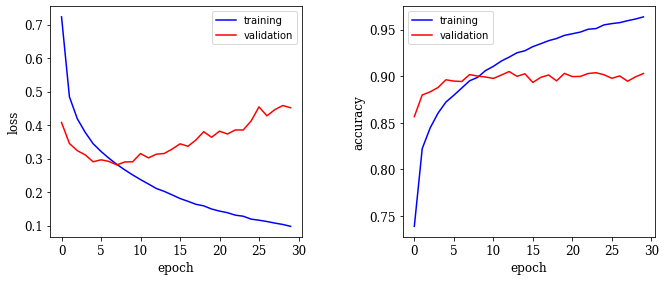

In [63]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(history.history['loss'],'-b', label = 'training')
axes[0].plot(history.history['val_loss'],'-r', label = 'validation')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('loss',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(history.history['accuracy'],'-b', label = 'training')
axes[1].plot(history.history['val_accuracy'],'-r', label = 'validation')
axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('accuracy',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

We can see that loss decreased and the accuracy increased with the number of epochs until the 8th epoch. After this epoch the model starts to overfit the data. The accuracy and loss at the 8th epoch is equal to 0.9 and 0.3 respectively. The performance is practically the same as the one obtained before without adding data with data augmentation techniques. 

In [81]:
# Compile The Model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Fit And Evaluate The Model Using Validation Dataset
history = model.fit(X_aug, y_aug, epochs=8, validation_data=(X_val, y_val))

Epoch 1/8
2688/2688 [==============================] - 53s 19ms/step - loss: 0.4507 - accuracy: 0.8347 - val_loss: 0.3385 - val_accuracy: 0.8736
Epoch 2/8
2688/2688 [==============================] - 52s 19ms/step - loss: 0.3923 - accuracy: 0.8543 - val_loss: 0.2941 - val_accuracy: 0.8909
Epoch 3/8
2688/2688 [==============================] - 53s 20ms/step - loss: 0.3575 - accuracy: 0.8666 - val_loss: 0.3002 - val_accuracy: 0.8924
Epoch 4/8
2688/2688 [==============================] - 52s 19ms/step - loss: 0.3283 - accuracy: 0.8780 - val_loss: 0.2665 - val_accuracy: 0.9036
Epoch 5/8
2688/2688 [==============================] - 52s 19ms/step - loss: 0.3049 - accuracy: 0.8862 - val_loss: 0.2892 - val_accuracy: 0.8960
Epoch 6/8
2688/2688 [==============================] - 52s 19ms/step - loss: 0.2832 - accuracy: 0.8937 - val_loss: 0.2761 - val_accuracy: 0.9060
Epoch 7/8
2688/2688 [==============================] - 54s 20ms/step - loss: 0.2672 - accuracy: 0.8995 - val_loss: 0.2632 - val_ac

In [86]:
loss, acc = model.evaluate(X_test, y_test, verbose = 1)
print('\nTest accuracy: %5.2f' %(acc))
print('\nTest loss: %5.2f' %(loss))

219/219 [==============================] - 2s 8ms/step - loss: 0.2713 - accuracy: 0.9039

Test accuracy:  0.90

Test loss:  0.27


Finally we can evaluate the model with the augmented data. A test accuracy equal to 90% is reached along with a loss equal to 0.27. The performance is the same with respect to the model build without data augmentation. The reason of this may be because the current data set is already large enough for the model to identify the patterns and behave properly, adding more data at this point may not have a high impact on the final results. However, the new model is more robust due to the ability to identify images that are not centered or images that are flip or shift, which is a strong advantage. 

## VARIATIONAL AUTO-ENCODER

A variational autoencoder (VAE) is implemented in this section. The objective is to train the model to generate new synthetic images using our data set. 

In [143]:
#! pip install tensorflow-probability

# to generate gifs
#! pip install imageio
#! pip install git+https://github.com/tensorflow/docs

In [144]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [145]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

The images data set is preprocess. The array data set is reshape to 4th dimensional array as batch x length x width x depth. The pixels are normalized to achieve values between 0 and 1. 

In [146]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [147]:
train_images = preprocess_images(X_train)
test_images = preprocess_images(X_test)

In [148]:
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 32

A tf data set is defined to save memory and ease the computations.

In [149]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                 .shuffle(test_size).batch(batch_size))

The encoder architecture is based on 2 two dimensional convolutional layers and a final dense layer. While the decoder architecture is based on a dense layer to change the images sizes from 28 by 28 to 32 by 32. After that 3 convolutional layers are follow with no activation for the last one. 

In [150]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [151]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

The model will be train with 10 epochs and 16 images will be generated

In [152]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [153]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [154]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -193.75596618652344, time elapse for current epoch: 90.1474711894989


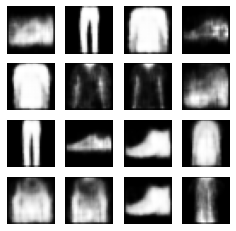

In [155]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Once the model is trained and the images are generated, we can visualize the results

In [160]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

The first image is just a random noisy input

(-0.5, 287.5, 287.5, -0.5)

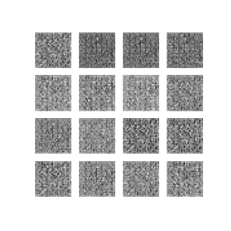

In [161]:
plt.imshow(display_image(0))
plt.axis('off')  # Display images

The second epoch is able to capture the features of the images and produces good results specially for the case of shoes and jackets. The t-shirts are still hard to visualize. 

(-0.5, 287.5, 287.5, -0.5)

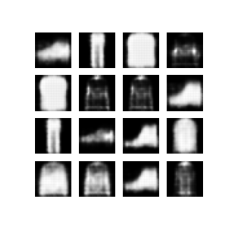

In [178]:
plt.imshow(display_image(1))
plt.axis('off')  # Display images

(-0.5, 287.5, 287.5, -0.5)

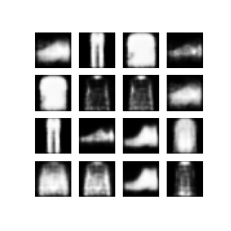

In [179]:
plt.imshow(display_image(2))
plt.axis('off')  # Display images

(-0.5, 287.5, 287.5, -0.5)

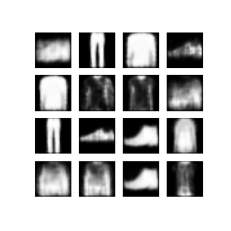

In [182]:
plt.imshow(display_image(5))
plt.axis('off')  # Display images

At the tenth epoch the t-shirts are better captured. The VAE is able to reproduce the images from our data set in a good quality. More number epochs should increased the performance of the model. However, it is expensive computionally and in this work 10 number of epochs is able to achieve the objectives. 

(-0.5, 287.5, 287.5, -0.5)

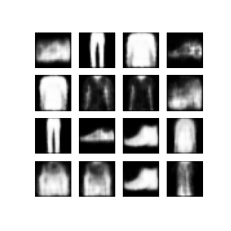

In [181]:
plt.imshow(display_image(10))
plt.axis('off')  # Display images

The model was trained for 10 epochs. The input for the first epoch was noisy images. The improvement of the model was immediate after the first epoch. At this point the images were able to capture the general features of each item. As the number of epochs increased the model was able to capture several details that lead to a good quality figure.  

# GAN

In [ ]:
import tensorflow as tf

In [ ]:
# To generate GIFs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1tb9bkgx
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-1tb9bkgx
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184397 sha256=46d3d8ea82efcef6466b630bcddea1a768977d43a9699b35fde2a3343b0842ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-txxo_brh/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# loading the data
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X = np.concatenate((X_train,X_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
np.random.seed(42)
A = np.arange(0,69999)
np.random.shuffle(A)
train, validate, test = np.split(A,[int(.8*len(A)), int(.9*len(A))])
X_train = X[train]
X_val = X[validate]
X_test = X[test]
y_train = y[train]
y_val = y[validate]
y_test = y[test]
print('X_train shape is: ' + str(X_train.shape))
print('X_val shape is:  '  + str(X_val.shape))
print('X_test shape is:  '  + str(X_test.shape))
print('y_train shape is: ' + str(y_train.shape))
print('y_val shape is:  '  + str(y_val.shape))
print('y_test shape is:  '  + str(y_test.shape))

X_train shape is: (55999, 28, 28)
X_val shape is:  (7000, 28, 28)
X_test shape is:  (7000, 28, 28)
y_train shape is: (55999,)
y_val shape is:  (7000,)
y_test shape is:  (7000,)


In [ ]:
train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

The generator model will create fake images. The model is a CNN, the architecture is defined below:

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

We can test the CNN generator model with untrained weights to check if the model is working. The input of the generator model will be an array of size 100 filled with random numbers sampled from a normal distribution. 

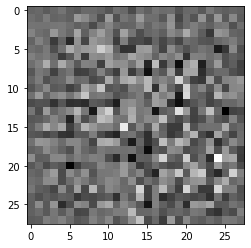

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

The DISCRIMINATOR model will be build as a CNN to classify images between real and fake. 

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

We can use the untrained discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00076879]], shape=(1, 1), dtype=float32)


The binary cross entropy loss function is used to assess both models performance. 

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

DISCRIMINATOR LOSS

To evaluate the performance of the Discriminator a metric is developed. it compares the discriminator's predictions on real images to an array of ones, and the discriminator's predictions on fake (generated) images to an array of 0s. 

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

GENERATOR LOSS 

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s. 

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are difference since you will train two networks separately. 

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Checkpoints can be used to save and restore models.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

DEFINE THE TRAINING LOOP 

In [ ]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The disminator is then used to classify real images (drwan from the trainin set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator. 

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)    #Noisy images

      real_output = discriminator(images, training=True)    # Classification done by the discriminator on real images
      fake_output = discriminator(generated_images, training=True) # Classification done by the discriminator on generated images

      gen_loss = generator_loss(fake_output)                 # The loss of the genetaror decreases when the discriminator consider its images to be real
      disc_loss = discriminator_loss(real_output, fake_output) # The loss of the discriminator decreases when classify real images as real and generated ones as fake. 

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    print(seed.shape)
    print(seed)
    
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Now, we can train the GAN model to generate synthetic images.

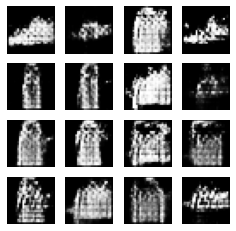

Time for epoch 33 is 727.4217131137848 sec


In [ ]:
train(train_dataset, 33)

After 33 epochs, the GAN model is able to generate synthetic images that capture the general features of the clothes. It suggests that the model is learning the features associated with each clothes item and with a larger number of epochs the model may reproduce high quality figures. The model was trained until the epoch 33. Each epoch takes around 730 seconds that is about 7 hours in total. It would have been better to have a larger number of epochs, e.g. 100, however Google colab will stop the run after 12 hrs. For the hw purposes, 33 epochs are considered fair enough to demonstrate the capability of the build GAN model. 

## CONCLUSIONS

The objective of this project is to develop a Convolutional Neural Network, Variational Auto Encoder and Generative Adversarial Network, to classify clothing articles based on images and reproduced high quality synthetic images. An exploratory data analysis was carried out. In this step, the images were visualized and the spareness of the data was analyzed. After that a convolutional neural network was build and the hyperparameters were tuned. The accuracy metric was used in this problem due to the nature of the project. There is no particular interest in classifying a particular item better over another one and the misclassification is not as serious as misclassifying a cancer patient for example. The metrics were above 90% and the model was proven to successfully classify non-trained images using the test data set. 

The pretrained models InceptionV3 and ResNet50 were used to classify the images in our data set. These models were trained using RGB images with larger number of pixels (299 by 299). Our images are grey scale, and the size is 28 by 28, therefore, the images were resized to 299 by 299 and transform to RGB by repeating the image along the depth axis. Nevertheless, the pretrained model were not able to correctly classify the images. Note that our data set has a low quality (28 by 28) and it is in grey scale. The pretrained models were not input this type of data, specially with the greyscale format. Therefore, it is expected that they are not able to properly classify the data set. It was proven that with a RGB image and medium quality the pretrained models can identify the clothes items. Although we can use the pretrained models with grayscale images by transforming them to RGB shape by repeating the image, the models may extract wrongly features of the transformed images, since the models are expecting an RGB image input.

Data augmentation techniques were implemented to increase the diversity of my data set. This approach is helpful when small data sets are available. In this section, random rotations, shift and flips are implemented to the images. 30000 new images are added to training data set. Note that the current training set presents 56000 images. The effect of increasing the diversity and samples of our data set was assessed. A test accuracy equal to 90% is reached. The performance is the same with respect to the model build without data augmentation. The reason of this may be because the current data set is already large enough for the model to identify the patterns and behave properly, adding more data at this point may not have a high impact on the final results. However, the new model is more robust due to the ability to identify images that are not centered or images that are flip or shift, which is a strong advantage.

A variational Auto Encoder was implemented to generate new images. The encoder architecture is based on 2 two dimensional convolutional layers and a final dense layer. While the decoder architecture is based on a dense layer to change the images sizes from 28 by 28 to 32 by 32. After that 3 convolutional layers are follow with no activation for the last one. The loss for the model was a cross entropy loss. The model was trained for 10 epochs. The input for the first epoch was noisy images. The improvement of the model was immediate after the first epoch. At this point the images were able to capture the general features of each item. As the number of epochs increased the model was able to capture several details that lead to a good quality figure.  The time of execution was about 20 minutes. 

Finally, a Generative Adversarial Network was implemented. The method is composed of a generator and a discriminator model. The generator’s architecture is based on a stack of 2D convolution, normalization and leaky reLU layers. The input to the generator is a noisy image. The discriminator is built with 2D convolution layers and LeakyReLu layers for non-linearity. The binary cross entropy loss is used to assess the model performance. After 33 epochs, the GAN model is able to generate synthetic images that capture the general features of the clothes. It suggests that the model is learning the features associated with each clothes item and with a larger number of epochs the model may reproduce high quality figures. The model was trained until the epoch 33. Each epoch takes around 730 seconds that is about 7 hours in total. It would have been better to have a larger number of epochs, e.g. 100, however Google colab will stop the run after 12 hrs. For the hw purposes, 33 epochs are considered fair enough to demonstrate the capability of the build GAN model. In this work with this data set the VAE proved to be more efficient than the GAN. Generally, in practice GANs produce better quality images, nevertheless, they are expensive computationally. 


